In [1]:
import pathlib
import urllib

import pandas as pd
from plotnine import *

# Load all ICD-10 UKBB phenotypes

In [2]:
phenotype_codes_df = pd.read_csv('../scripts/neale_aws_files.txt', header=None, names=['url'])

phenotype_codes_df.head(2)

,url
0,https://broad-ukb-sumstats-us-east-1.s3.amazon...
1,https://broad-ukb-sumstats-us-east-1.s3.amazon...


In [3]:
codes_df = (
    phenotype_codes_df
    .assign(
        file_name=lambda df: df['url'].apply(lambda x: pathlib.Path(urllib.parse.urlparse(x).path).name),
        code=lambda df: df['file_name'].apply(lambda x: x.split('.')[0])
    )
    .drop(columns=['url', 'file_name'])
)

codes_df.to_csv('../data/phenotypes_meta/all_ukbb_icd_codes.csv', index=False, header=False)

codes_df.head(2)

,code
0,A04
1,A08


# Apply heritability filters

1. Heritability estimate must have confidence > "none"
2. Phenotype must be "primary"

In [4]:
heritability_df = pd.read_csv(
    '../data/neale_heritability_estimates/ukb31063_h2_all.02Oct2019.tsv.gz',
    usecols=['phenotype', 'sex', 'n_missing', 'n', 'n_cases', 'n_controls', 'h2_liability', 
             'h2_liability_se', 'h2_z', 'h2_p', 'isBinary', 'phen_stem', 'Neff', 'prevalence', 
             'keep', 'notes', 'confidence', 'conf_simple', 'isNotPrimary'], sep='\t', compression='gzip'
)

heritability_df.head(2)

,phenotype,sex,n_missing,n,n_cases,n_controls,h2_liability,h2_liability_se,h2_z,h2_p,phen_stem,isBinary,Neff,prevalence,keep,notes,confidence,isNotPrimary,conf_simple
0,100001_irnt,both_sexes,309741,51453,NaN,NaN,0.068818,0.016857,4.082528,0.000022,100001,False,51453.0,NaN,True,NaN,high,False,high
1,100001_raw,both_sexes,309741,51453,NaN,NaN,0.069468,0.016275,4.268457,0.000010,100001,False,51453.0,NaN,False,drop_cont_raw;isNotPrimary;,NA_(not_primary),True,NaN


In [5]:
icd_heritability_df = (
    heritability_df
    .merge(codes_df, left_on='phenotype', right_on='code')
    .query('(sex == "both_sexes") & (confidence != "none") & (isNotPrimary == False)')
    .drop(columns=['code'])
)

icd_heritability_df.head(2)

,phenotype,sex,n_missing,n,n_cases,n_controls,h2_liability,h2_liability_se,h2_z,h2_p,phen_stem,isBinary,Neff,prevalence,keep,notes,confidence,isNotPrimary,conf_simple
6,A09,both_sexes,0,361194,2161.0,359033.0,-0.029687,0.043285,-0.685859,0.753599,A09,True,8592.28,0.005983,True,isLowNeff;,low,False,low
36,C18,both_sexes,0,361194,2226.0,358968.0,0.120329,0.042461,2.833887,0.002299,C18,True,8849.13,0.006163,True,isLowNeff;,low,False,low


# Apply genetic covariance filters

1. Only phenotypes that have all genetic covariances not NA.

In [6]:
ldsc_df = pd.read_csv('../data/neale_heritability_estimates/geno_correlation.r2.gz', 
                      compression='gzip', sep='\s+', usecols=['p1', 'p2', 'rg', 'se', 'p'])

ldsc_df.head(2)

,p1,p2,rg,se,p
0,../../results/UKbb/ldsc-additive-export/sumsta...,../../results/UKbb/ldsc-additive-export/sumsta...,0.9998,0.002135,0.000000e+00
1,../../results/UKbb/ldsc-additive-export/sumsta...,../../results/UKbb/ldsc-additive-export/sumsta...,0.6925,0.091160,3.041000e-14


In [7]:
ldsc_processed_df = (
    ldsc_df
    .assign(
        p1=lambda df: df['p1'].apply(lambda x: pathlib.Path(x).name),
        p1_parts=lambda df: df['p1'].apply(lambda x: x.split('.')),
        p1_code=lambda df: df['p1_parts'].apply(lambda l: l[0]),
        p1_method=lambda df: df['p1_parts'].apply(lambda l: l[1]),
        p1_data=lambda df: df['p1_parts'].apply(lambda l: l[2]),
        p1_sex=lambda df: df['p1_parts'].apply(lambda l: l[3]),
        
        p2=lambda df: df['p2'].apply(lambda x: pathlib.Path(x).name),
        p2_parts=lambda df: df['p2'].apply(lambda x: x.split('.')),
        p2_code=lambda df: df['p2_parts'].apply(lambda l: l[0]),
        p2_method=lambda df: df['p2_parts'].apply(lambda l: l[1]),
        p2_data=lambda df: df['p2_parts'].apply(lambda l: l[2]),
        p2_sex=lambda df: df['p2_parts'].apply(lambda l: l[3]),
    )
    .query('(p1_method == "ldsc") & (p1_data == "imputed_v3") & (p1_sex == "both_sexes") & '
           '(p2_method == "ldsc") & (p2_data == "imputed_v3") & (p2_sex == "both_sexes")')
    .drop(columns=['p1_parts', 'p1_method', 'p1_data', 'p1_sex', 
                   'p2_parts', 'p2_method', 'p2_data', 'p2_sex'])
)

ldsc_processed_df.head(2)

,p1,p2,rg,se,p,p1_code,p2_code
0,100001_irnt.ldsc.imputed_v3.both_sexes.tsv.bgz,100001_raw.ldsc.imputed_v3.both_sexes.tsv.bgz,0.9998,0.002135,0.000000e+00,100001_irnt,100001_raw
1,100001_irnt.ldsc.imputed_v3.both_sexes.tsv.bgz,100002_irnt.ldsc.imputed_v3.both_sexes.tsv.bgz,0.6925,0.091160,3.041000e-14,100001_irnt,100002_irnt


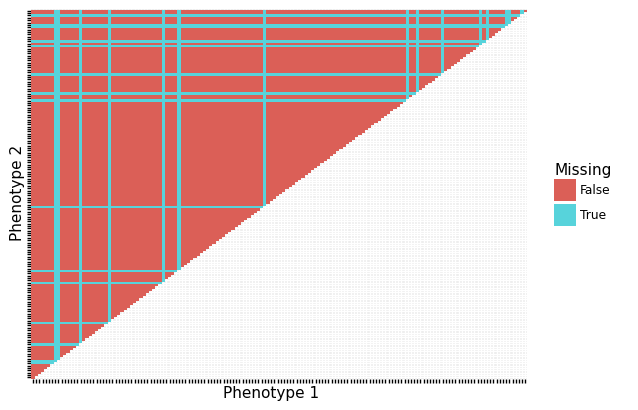

<ggplot: (8756498816377)>

In [15]:
plot_df = (
    ldsc_processed_df
    .merge(icd_heritability_df['phenotype'], left_on='p1_code', right_on='phenotype')
    .merge(icd_heritability_df['phenotype'], left_on='p2_code', right_on='phenotype')
    .drop(columns=['phenotype_x', 'phenotype_y'])
    .assign(fill=lambda df: df['rg'].isna())
)

(
    ggplot(plot_df, aes(x='p1_code', y='p2_code', fill='fill')) +
    geom_tile() +
    theme(axis_text = element_blank()) +
    xlab('Phenotype 1') +
    ylab('Phenotype 2') +
    scale_fill_discrete(name='Missing')
)

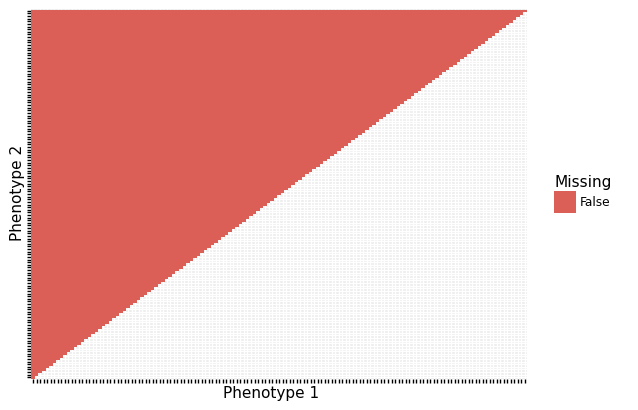

<ggplot: (8755827666966)>

In [16]:
plot_df = (
    ldsc_processed_df
    .merge(icd_heritability_df['phenotype'], left_on='p1_code', right_on='phenotype')
    .merge(icd_heritability_df['phenotype'], left_on='p2_code', right_on='phenotype')
    .drop(columns=['phenotype_x', 'phenotype_y'])
    .dropna()
    .assign(fill=lambda df: df['rg'].isna())
)

(
    ggplot(plot_df, aes(x='p1_code', y='p2_code', fill='fill')) +
    geom_tile() +
    theme(axis_text = element_blank()) +
    xlab('Phenotype 1') +
    ylab('Phenotype 2') +
    scale_fill_discrete(name='Missing')
)

# Final phenotype list

In [13]:
phenotypes_to_use = sorted(set(
    ldsc_processed_df
    .merge(icd_heritability_df['phenotype'], left_on='p1_code', right_on='phenotype')
    .merge(icd_heritability_df['phenotype'], left_on='p2_code', right_on='phenotype')
    .dropna()
    .loc[:, ['phenotype_x', 'phenotype_y']]
    .values
    .flatten()
))

print(len(phenotypes_to_use))

print(phenotypes_to_use[:4])

with open('../data/phenotypes_meta/chosen_icd_codes.csv', 'w') as f:
    f.writelines([p + '\n' for p in phenotypes_to_use])

142


['A09', 'C18', 'C34', 'C43']

In [25]:
p = set(phenotypes_to_use)

relevant_genetic_correlation_df = (
    ldsc_processed_df
    .loc[:, ['p1_code', 'p2_code', 'rg', 'se', 'p']]
    .loc[lambda df: df['p1_code'].apply(lambda x: x in p)]
    .loc[lambda df: df['p2_code'].apply(lambda x: x in p)]
    .reset_index(drop=True)
    .rename(columns={'p1_code': 'p1', 'p2_code': 'p2'})
)

relevant_genetic_correlation_df.to_csv('../data/phenotypes_meta/genetic_correlation.tsv', sep='\t', index=False)

relevant_genetic_correlation_df.head(2)

,p1,p2,rg,se,p
0,A09,C18,-1.01300,1.0920,0.3535
1,A09,C34,-0.07082,0.6842,0.9176
